# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В представленных нам данных содержаться следующие признаки:

DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer— пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
Целевой признак:  

Price — цена (евро)  

Для решения задачи мы будем придерживатья следующих шагов:  

Изучим и подготовим для машинного обучения данные  
 
Создадим несколько видов ML-моделей, основанных на разных алгоритмах  

Выберем лучший алгоритм по ряду параметров и посчитаем на нём контрольную метрику на тестовых данных  

Подведём итог проделанной работе  

## Подготовка данных

Импортируем библиотеки:

In [10]:
#импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

!pip install --upgrade pip

!pip install catboost

!pip install category_encoders

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                Ridge, 
                LinearRegression
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ( 
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import (
    mean_squared_error, 
    make_scorer
)


RANDOM_STATE = 666

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Загрузим датафрейм:

In [11]:
df = pd.read_csv('autos.csv')

Создадим функцию функцию, которая будет на вход принимает датафрейм, а на выходе выводит необходимые характеристики

In [12]:
def df_info(dataframe):
    print('Общая информация по датафрейму:')
    display(dataframe.info())
    print('\nПервые 10 строк:')
    display(dataframe.head(10))
    print('\nПоследние 10 строк:')
    display(dataframe.tail(10))
    print('\nПропуски:')
    display(dataframe.isnull().sum().sort_values(ascending=False))
    print('\nОписание датафрейма:')
    display(dataframe.describe())
    print('\nКоличество дубликатов:')
    display(dataframe.duplicated().sum())  
    num_columns, cat_columns = [], []
    for num, i in enumerate(dataframe.columns):
        if pd.api.types.is_numeric_dtype(dataframe[i]):
            print(
                f'{num+1}. {i} - тип данных int64, уникальных значений: {len(dataframe[i].unique())}')
            num_columns.append(i)
        elif pd.api.types.is_object_dtype(dataframe[i]):
            print(
                f'{num+1}. {i} - тип данных object, уникальных значений: {len(dataframe[i].unique())}')
            cat_columns.append(i)
    print(
        f'\nИтого:\nпризнаки с типом данных int64: {len(num_columns)}\nпризнаки с типом данных object: {len(cat_columns)}')

In [13]:
df_info(df)

Общая информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  

None


Первые 10 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06



Последние 10 строк:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354359,2016-03-28 13:48:07,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no,2016-03-28 00:00:00,0,75223,2016-04-02 18:16:20
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21



Пропуски:


Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


Описание датафрейма:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Количество дубликатов:


4

1. DateCrawled - тип данных object, уникальных значений: 271174
2. Price - тип данных int64, уникальных значений: 3731
3. VehicleType - тип данных object, уникальных значений: 9
4. RegistrationYear - тип данных int64, уникальных значений: 151
5. Gearbox - тип данных object, уникальных значений: 3
6. Power - тип данных int64, уникальных значений: 712
7. Model - тип данных object, уникальных значений: 251
8. Kilometer - тип данных int64, уникальных значений: 13
9. RegistrationMonth - тип данных int64, уникальных значений: 13
10. FuelType - тип данных object, уникальных значений: 8
11. Brand - тип данных object, уникальных значений: 40
12. Repaired - тип данных object, уникальных значений: 3
13. DateCreated - тип данных object, уникальных значений: 109
14. NumberOfPictures - тип данных int64, уникальных значений: 1
15. PostalCode - тип данных int64, уникальных значений: 8143
16. LastSeen - тип данных object, уникальных значений: 179150

Итого:
признаки с типом данных int64: 7
признаки с т

В датафрейме 16 признаков и 354369 объектов.    
Названия признаков стоит привести к snake_case.  
В данный по пяти признакам присутствуют пропущенные значения.  
Обнаружено 4 явных дубликата, который будем удалять.  
7 признаков имеют тип данных int64, 9 признаков имеют тип данных object.   

**Рассмотрим подробнее признаки на предмет наличия аномальных значений и значимость для обучения модели.**

Приведем названия признаков к snake_case и удалим явные дубликаты

In [14]:
for i, s in enumerate(df.columns):
    s = ''.join(['_' + c.lower() if c.isupper() else c for c in s]).lstrip('_')
    df = df.rename(columns={df.columns[i]: s})
    
df[df.select_dtypes(include=['object']).columns] =\
    df[df.select_dtypes(include=['object']).columns].apply(lambda x: x.str.lower())

df.drop_duplicates(inplace=True)

print(f'теперь дубликатов: {df.duplicated().sum()}')
df.head(2)

теперь дубликатов: 0


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


Признак **number_of_pictures'** (количество фотографий автомобиля)
Признак неинформативен и содержит одно уникальное значение - 0, поэтому удалим его.  
Но перед этим объявим переменную, которая будет отражать исходный размер датафрейма, чтобы можно было контролировать объем удаляемых данных.

In [15]:
start_size = df.shape

In [16]:
df = df.drop(['number_of_pictures'], axis=1)

Для  признаков **date_created** - дата создания анкеты
**last_seen** - дата последней активности пользователя
**date_crawled** - дата скачивания анкеты из базы
изменим формат со str на datetime и посмотрим на их распределение

In [17]:
# Создадим функцию, которая приводит признаки к типу datetime и выводит графики и сводную таблицу по начальным и конечным датам для каждого признака:

def plot_date_columns(data, date_columns):
    min_max_dates = pd.DataFrame(columns=['Признак', 'Начальная дата', 'Конечная дата'])
    for column in date_columns:
        df[column] = pd.to_datetime(df[column])
        min_date = df[column].min()
        max_date = df[column].max()
        min_max_dates = pd.concat([min_max_dates, pd.DataFrame(
            {'Признак': [column], 'Начальная дата': [min_date], 'Конечная дата': [max_date]})])
        plt.figure(figsize=(12, 5))
        df[column].hist(bins=100, grid=True)
        plt.title(f'Распределение значений по {column}')
        plt.xlabel('Количество наблюдений')
        plt.ylabel(column)
        plt.show()

    return min_max_dates

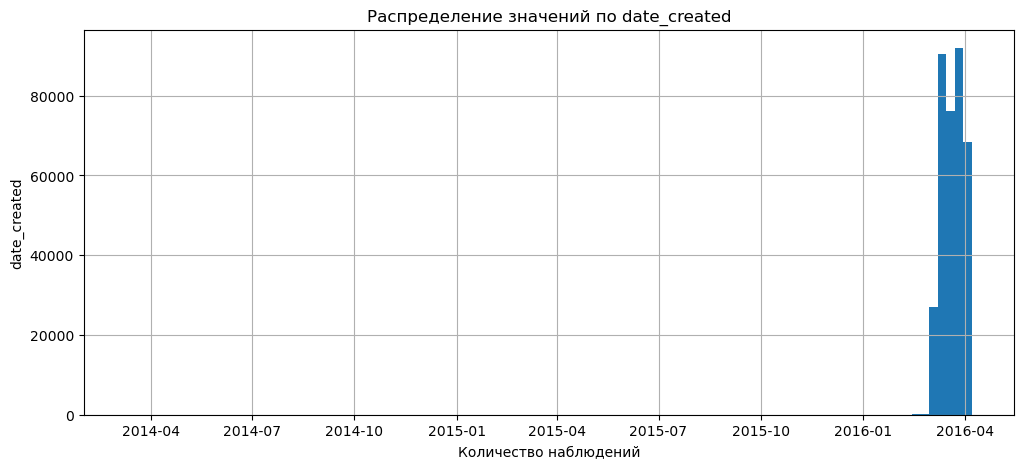

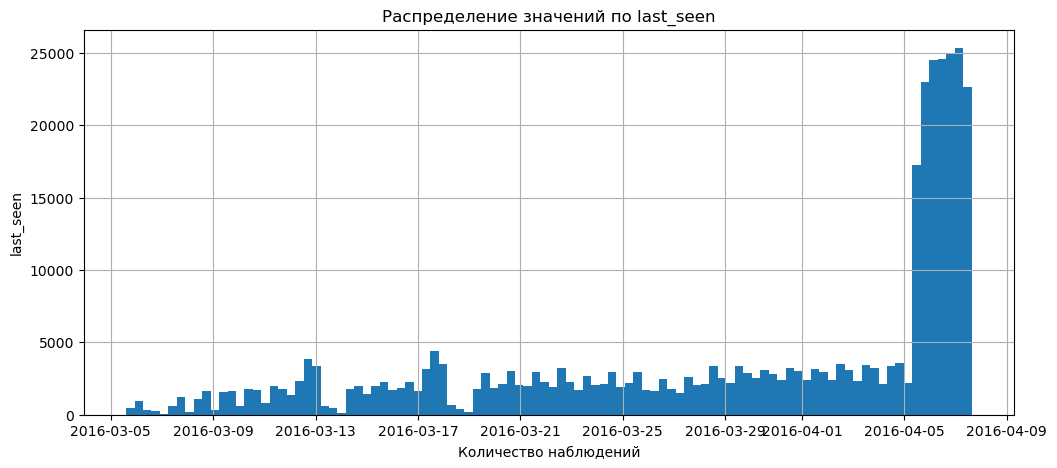

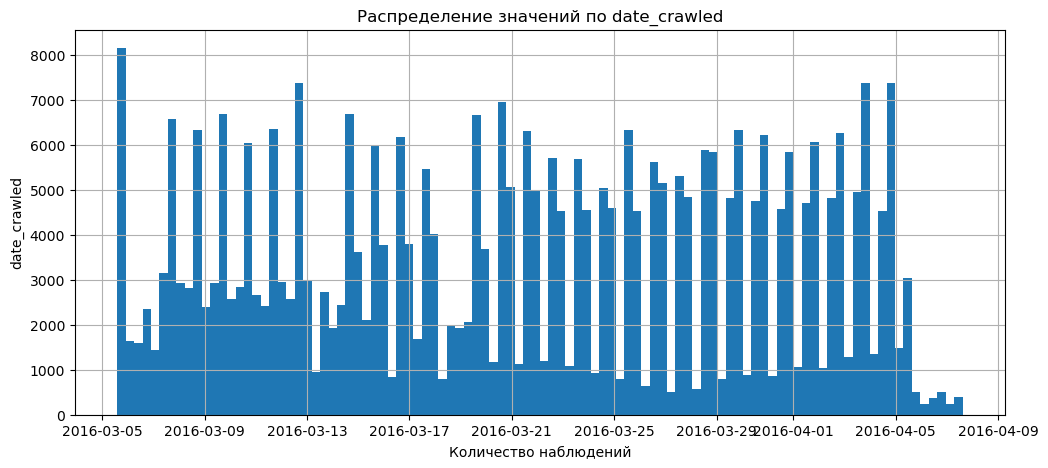

,Признак,Начальная дата,Конечная дата
0,date_created,2014-03-10 00:00:00,2016-04-07 00:00:00
0,last_seen,2016-03-05 14:15:08,2016-04-07 14:58:51
0,date_crawled,2016-03-05 14:06:22,2016-04-07 14:36:58


In [18]:
date_columns = ['date_created', 'last_seen', 'date_crawled']
min_max_dates = plot_date_columns(df, date_columns)
display(min_max_dates)

In [19]:
# Посмотрим на признаки с датами создания анкет в 2014 - 2015 годах:
display(df[df['date_created'].between('2014-01-01', '2015-12-31')
             ].sort_values(by='date_created')[['date_created', 'date_crawled', 'last_seen']])

,date_created,date_crawled,last_seen
61207,2014-03-10,2016-03-16 11:48:06,2016-04-07 04:46:24
4001,2015-03-20,2016-03-23 14:42:46,2016-04-07 03:45:01
342275,2015-06-18,2016-03-05 21:44:26,2016-04-05 17:46:09
86601,2015-08-07,2016-04-02 19:47:40,2016-04-07 09:15:23
175103,2015-08-10,2016-03-08 17:57:45,2016-04-05 20:46:54
75598,2015-09-04,2016-03-14 08:43:53,2016-03-15 14:16:58
221002,2015-09-04,2016-03-15 01:56:49,2016-03-15 15:49:29
340616,2015-09-09,2016-03-05 21:51:02,2016-04-05 17:46:04
9972,2015-11-02,2016-03-05 17:53:53,2016-03-17 15:46:57
161567,2015-11-08,2016-03-05 14:31:01,2016-04-06 23:15:36


Признак **date_created** (дата создания анкеты) - выборка охватывает временной период с 10.03.2014 г. по 07.04.2016 г. Основной массив данных относится к первым четырем месяцам 2016 г., небольшая часть относится к 2015 г. Обнаружена одна анкета с датой создания в 2014 г. и датой последней активности в 2016 г.  
Признак **date_crawled** (дата скачивания анкеты из базы) - данные равномерно распределены в промежутке с 05.03.2016 по 09.04.2016.  
Признак **last_seen** (дата последней активности пользователя) - данные, как и в признаке **date_crawled** (дата скачивания анкеты из базы) равномерно распределены в промежутке с 05.03.2016 по 09.04.2016.  
Вышеупомянутые признаки не влияют на процесс ценообразования и могут помешать нам при обучении модели, поэтому удалим/

In [20]:
df = df.sort_values('date_created').reset_index(drop=True)

df.drop(columns=date_columns, inplace=True)

Признаки **registration_year** - год регистрации автомобиля и **registration_month** - месяц регистрации автомобиля не содержат пропусков в данных. 
При этом у нас 151 разных значений лет и 13 месяцев, оригинально). Проверим, с какими годами мы имеем дело:

In [21]:
np.sort(df['registration_year'].unique())

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Средневековье, возрождение и далёкое будущее в признаке.

Все имеющиеся объявления были опубликованы в конкретное время с 2014-й по 2016-й год.
Первые серийные автомобили появились около 1914 года, а последняя публикация в выборке датирована 2016-04-07, посмотрим на количество анкет вне этого диапазона и удалим их.

In [22]:
print('Количество анкет ранее 1910 года:', len(df[df['registration_year'] < 1910]))
print('Количество анкет позднее 2016 года:',  len(df[df['registration_year'] > 2016]))

df = df[(df['registration_year'] >= 1910) & (df['registration_year'] <= 2016)]

print('Анкет ранее 1910 года осталось:', len(df[df['registration_year'] < 1910]))
print('Анкет позднее 2016 года осталось:',  len(df[df['registration_year'] > 2016]))

Количество анкет ранее 1910 года: 66
Количество анкет позднее 2016 года: 14530
Анкет ранее 1910 года осталось: 0
Анкет позднее 2016 года осталось: 0


In [23]:
df['registration_year'].describe()

count    339769.000000
mean       2002.482236
std           7.091220
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

Распределение анкет по годам на графике:

In [24]:
def plot_distribution(x, y, xlabel, ylabel, title, rotation=0, h=False):
    if h:
        plt.figure(figsize=(15, 8))
        plt.barh(x, y)
        axis_ = 'x'
    else:
        plt.figure(figsize=(15,5))
        plt.bar(x, y)
        axis_ = 'y'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if len(x) <= 14:
        plt.xticks(range(len(x)), x, rotation=rotation)
    else:
        plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', axis=axis_, linewidth=.5)
    plt.grid(which='minor', axis=axis_, linewidth=.25, linestyle='--')
    
    plt.show()

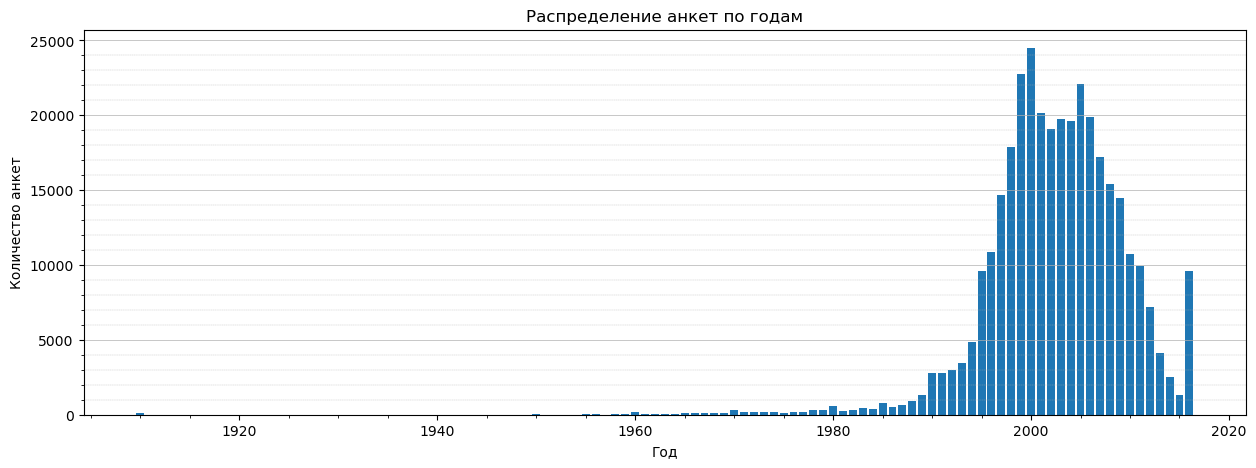

In [25]:
inform_hist = df['registration_year'].value_counts().sort_index().reset_index()
inform_hist.columns = ['year', 'count']

plot_distribution(inform_hist['year'], inform_hist['count'],
                  'Год', 'Количество анкет', 'Распределение анкет по годам')

На графике длинный хвост слева: регистрация автомобилией в заметном объеме представлена с 1980-1985х годов. Хвост до 1980 года будем считать аномальным. Посмотрим на количество анкет в нем и удалим.

In [26]:
print('Анкет ранее 1980 года осталось:', len(df[df['registration_year'] < 1980]))

Анкет ранее 1980 года осталось: 3386


In [27]:
df = df[df['registration_year'] > 1980]
print('Анкет ранее 1980 года осталось:', len(df[df['registration_year'] < 1980]))

Анкет ранее 1980 года осталось: 0


Посмотрим, почему в **registration_month** 13 уникальных значений и как распределено количество анкет

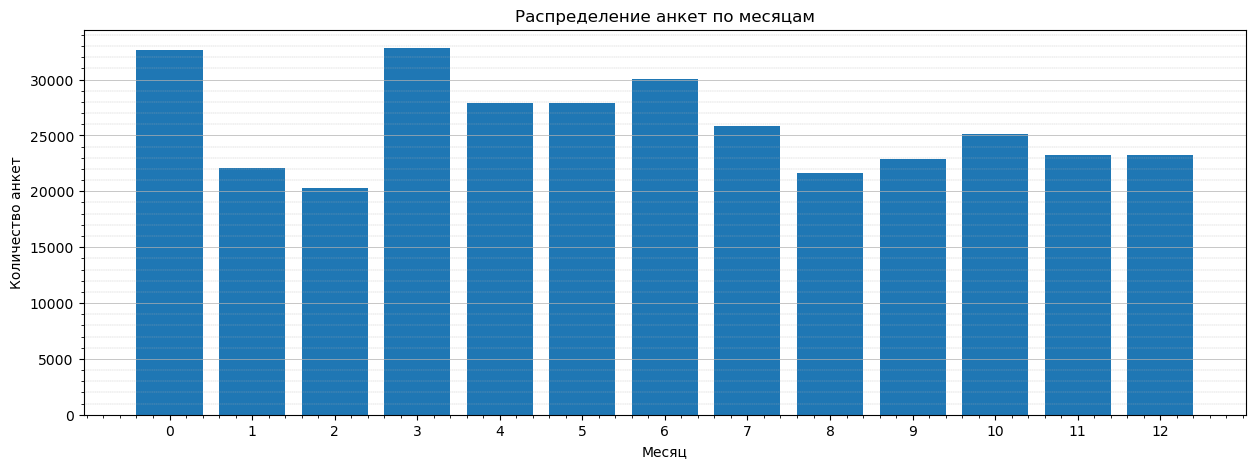

In [28]:
inform_hist = df['registration_month'].value_counts().sort_index().reset_index()
inform_hist.columns = ['month', 'count']

plot_distribution(inform_hist['month'], inform_hist['count'],
                  'Месяц', 'Количество анкет', 'Распределение анкет по месяцам')

13й месяц - это месяц под номером 0. Возможно это условное обозначение пропуска в данных. Проверим, на какие года приходится месяц 0

In [29]:
np.sort(df.loc[df['registration_month'] == 0, 'registration_year'].unique())

array([1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016], dtype=int64)

Значение 0 в признаке **registration_month** присутствует во всех годах, точно сказать, что это значение является обозначением пропуска данных, нельзя.  Признак **registration_month** не влияет на ценообразование,  следовательно, удалим его.

In [30]:
df.drop(columns='registration_month', axis=1, inplace=True)

И проверим, какой объем объектов мы удалили к текущему моменту

In [31]:
f'Удалено {start_size[0] - df.shape[0]} строк, \
что составляет {1-df.shape[0] / start_size[0]:.2%} от изначального датафрейма'

'Удалено 18570 строк, что составляет 5.24% от изначального датафрейма'

5.24% - приемлемо

Вместо года регистрации создадим столбец с возрастом авто, а столбец с годом регистрации удалим. Возрас авто влияет на цену, поэтому для обучения будет неплохо.

In [32]:
df['car_age'] = 2016 - df['registration_year']
df.drop(columns='registration_year', axis=1, inplace=True)
df.head(5)

,price,vehicle_type,gearbox,power,model,kilometer,fuel_type,brand,repaired,postal_code,car_age
0,8999,NaN,NaN,0,147,125000,petrol,alfa_romeo,NaN,79669,11
1,6000,bus,auto,200,other,150000,petrol,chevrolet,no,24558,21
2,10400,bus,NaN,0,ducato,30000,gasoline,fiat,NaN,76275,23
3,14250,convertible,manual,163,slk,150000,petrol,mercedes_benz,no,76228,11
4,5200,convertible,manual,109,2_reihe,80000,petrol,peugeot,no,26382,10


Признак **postal_code** так же удалим, он не понадобится.

In [33]:
df.drop(columns='postal_code', axis=1, inplace=True)

Посмотрим на признае **fuel_type**

In [34]:
df.fuel_type.value_counts()

petrol      207222
gasoline     96144
lpg           5134
cng            539
hybrid         223
other          162
electric        88
Name: fuel_type, dtype: int64

Переименуем gasoline в petrol: оба означают "бензин", пропуски заполним позже

In [35]:
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol')

Признак **brand** и **model** (марка автомобиля)  
В признаке **brand** содержется 40 уникальных значений, пропущенные данные отсутствуют.

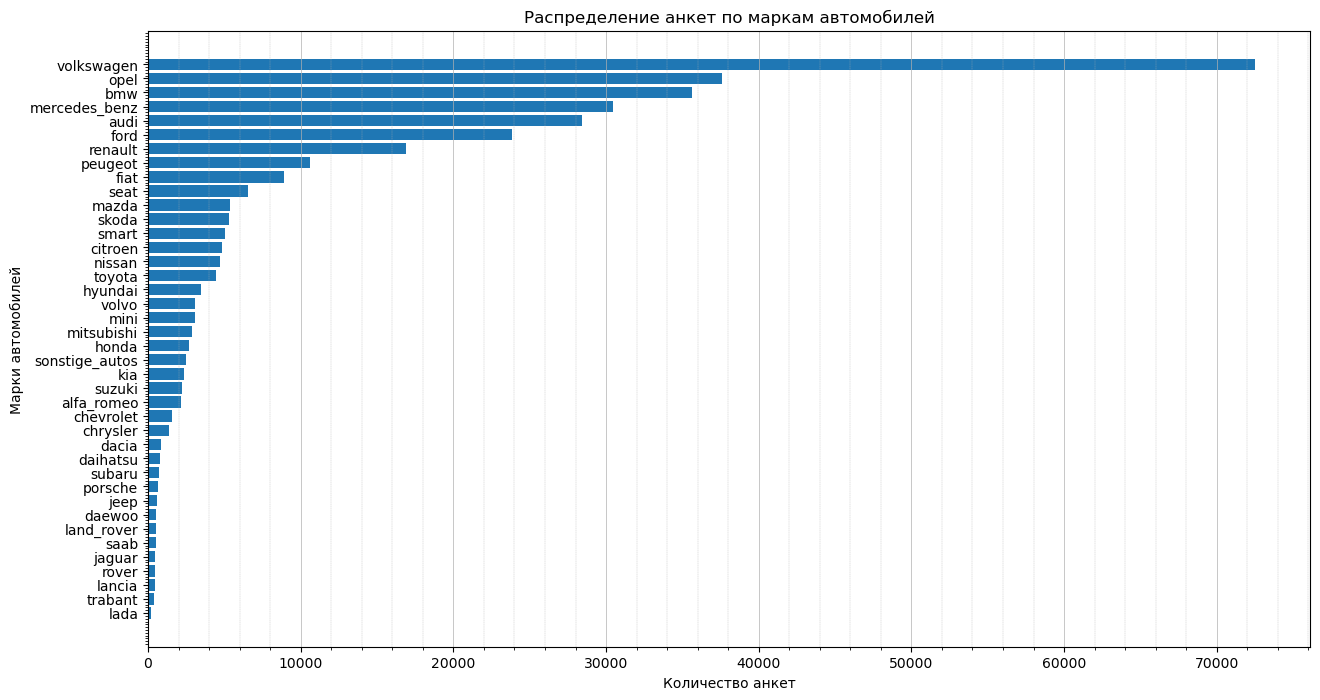

In [36]:
inform_hist = df['brand'].value_counts().sort_index().reset_index()
inform_hist.columns = ['brand', 'count']
inform_hist = inform_hist.sort_values('count')
plot_distribution(inform_hist['brand'], inform_hist['count'],
                  'Количество анкет', 'Марки автомобилей', 'Распределение анкет по маркам автомобилей', h=True)

Клиенты сервиса "Не бит, не крашен" предпочитают немецкие автомобили. 'sonstige_autos' означает "другие автомобили", т.е. бренды не указаны в принципе, избавимся от этих объектов.

In [37]:
df = df[df['brand'] != 'sonstige_autos']

In [38]:
print('Количество пропущеных значений:', df['model'].isnull().sum())

Количество пропущеных значений: 14144


Пропуски в **model** заполним заглушкой

In [39]:
df['model'] = df['model'].fillna('unknown')
print('Количество пропущеных значений:', df['model'].isnull().sum())

Количество пропущеных значений: 0


**vehicle_type** - тип автомобильного кузова  
**gearbox** - тип коробки передач  
**fuel_type** - тип топлива  
Все эти 3 признака относятся к техническим характеристикам автомобилей:

In [40]:
isna_ = df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].isna().sum()
notnull_ = df.loc[:, ['vehicle_type', 'gearbox', 'fuel_type']].notnull().sum()
print(f"% пропусков:\n{np.round((isna_ / notnull_)*100, 2)}")

% пропусков:
vehicle_type    6.89
gearbox         5.10
fuel_type       8.28
dtype: float64


В этих признаках от 5 до 8% пропусков

Посмотрим на количество пропущенных значений, которые присутвуют во всех трех признаках:

In [41]:
df[(df['vehicle_type'].isnull()) & (df['gearbox'].isnull()) & (df['fuel_type'].isnull())].shape[0]

4907

Эти объекты не будут полезными при обучении модели - удалим их, а остальные пропуски заполним заглушкой

In [42]:
df.dropna(subset=['vehicle_type', 'gearbox', 'fuel_type'], how='all', inplace=True)

tech_features = ['vehicle_type', 'gearbox', 'fuel_type']

for feature in tech_features:
    df[feature] = df[feature].fillna('unknown')
    missing_values = df[feature].isnull().sum()
    print(f"Для признака '{feature}':")
    print(f"Количество пропущенных значений: {missing_values}")
    print()

Для признака 'vehicle_type':
Количество пропущенных значений: 0

Для признака 'gearbox':
Количество пропущенных значений: 0

Для признака 'fuel_type':
Количество пропущенных значений: 0



Проверим, сколько данный удалено к этому моменту от изначального размера данных:

In [43]:
f'{1-df.shape[0] / start_size[0]:.2%}'

'7.33%'

Пока в пределах нормы, идем дальше по признакам

Признак **repaired** (была машина в ремонте или нет)
Это категориальный признак, содержащий 2 значения с большим количеством пропусков. Посмотрим на него:

In [44]:
print(f"Количество пропущенных значений: {df['repaired'].isnull().sum()} что составляет \
{df['repaired'].isnull().sum() / df['repaired'].notnull().sum():.2%} от количества значений")

Количество пропущенных значений: 57830 что составляет 21.37% от количества значений


Слишком большой объем для удаления, поэтому заполним заглушкой

In [45]:
df['repaired'] = df['repaired'].fillna('unknown')
print('Количество пропущеных значений:', df['repaired'].isnull().sum())

Количество пропущеных значений: 0


Признак **power** (мощность (л. с.))
Это важный признак, влияющий на ценообразование. Посмотрим на него:

In [46]:
df['power'].value_counts().sort_index()

0        29821
1           21
2            8
3            1
4            6
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: power, Length: 690, dtype: int64

В распределении есть и нули, и огромные значения. Посмотрим на графике:

In [47]:
def get_boxplot(df, title, xlim):
    plt.figure(figsize=(15, 6))
    sns.boxplot(x=df)
    plt.title(title)
    plt.xlim(xlim)
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.show()

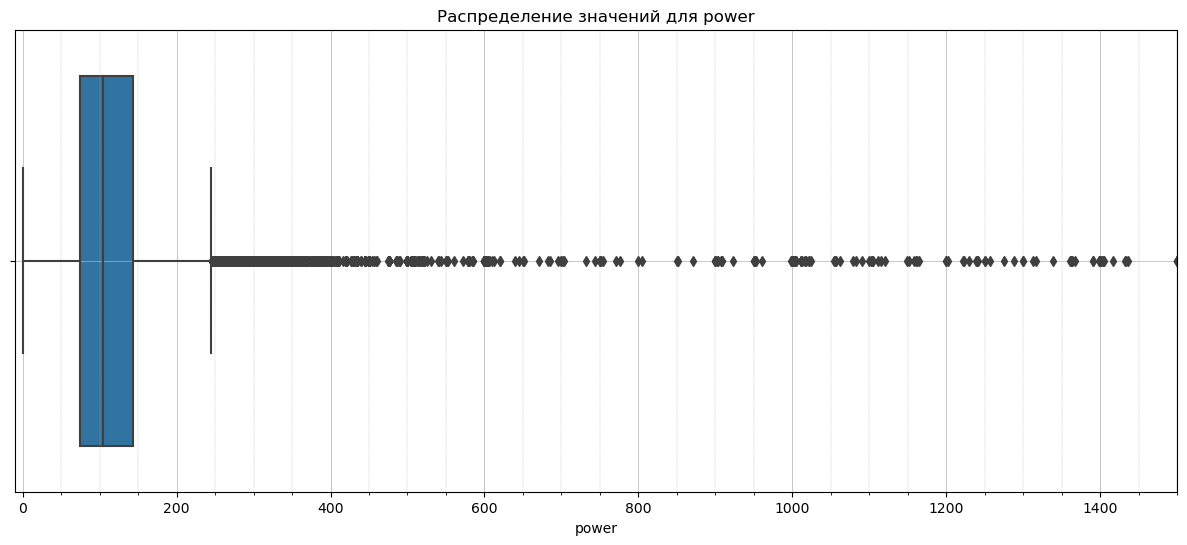

In [48]:
get_boxplot(df['power'], 'Распределение значений для power', (-10, 1500))

Погуглив самые маломощные автомобили, проверяем машины с морозностью 5, 9, 15 л.с., будем удалять машины с неадекватными значениями мощности по первой "адекватной"

In [49]:
df.loc[df['power'] == 5, ['model','brand', 'power','car_age']].sort_values('power', ascending=True)

,model,brand,power,car_age
14597,lupo,volkswagen,5,0
105975,twingo,renault,5,16
123606,5_reihe,mazda,5,10
136864,other,seat,5,22
144107,polo,volkswagen,5,15
144332,other,seat,5,21
181570,twingo,renault,5,17
194289,corsa,opel,5,14
215277,fiesta,ford,5,12
219704,unknown,renault,5,2


In [50]:
df.loc[df['power'] == 9, ['model','brand', 'power', 'car_age']].sort_values('power', ascending=True)

,model,brand,power,car_age
201963,other,citroen,9,17
284484,unknown,fiat,9,25


In [51]:
df.loc[df['power'] == 15, ['model','brand', 'power', 'car_age']].sort_values('power', ascending=True)

,model,brand,power,car_age
5877,unknown,fiat,15,26
14797,other,renault,15,2
65048,unknown,bmw,15,13
80368,fabia,skoda,15,8
104166,3er,bmw,15,21
147193,500,fiat,15,20


Самым мощным автомобилем может быть Ford Mustang Shelby GT500 (2007-2014), мощность двигателя - 662 л.с., сымым маломощным Фиат 500. По этим данным и будем резать нашу выборку.

In [52]:
df = df[(df['power'] >= 15) & (df['power'] <= 662)]

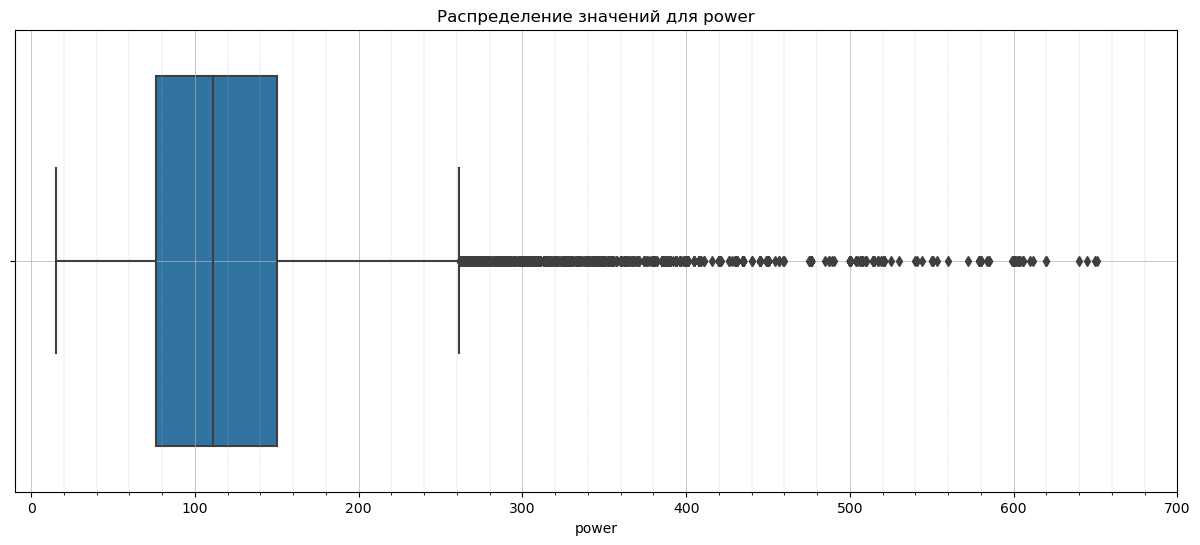

In [53]:
get_boxplot(df['power'], 'Распределение значений для power', (-10, 700))

In [54]:
f'{1-df.shape[0] / start_size[0]:.2%}'

'15.86%'

Немало, но мы избавились от аномальных значений, которые могут мешать обучению модели.

Признак **kilometer** (пробег (км))
Важный числовой признак с малым количеством уникальных значений. Есть вероятность, что это категориальный признак. Посмотрим на него:

In [55]:
df['kilometer'].value_counts().sort_index()

5000        2856
10000        871
20000       3172
30000       3815
40000       4415
50000       5535
60000       6695
70000       7643
80000       8916
90000      10217
100000     12603
125000     31842
150000    199572
Name: kilometer, dtype: int64

In [56]:
def get_histplot(df, xlabel, rotation=0, kde=True):
    plt.figure(figsize=(15,5))
    sns.histplot(df, linewidth=5, ec='#0073bb')
    plt.xlabel(xlabel)
    plt.ylabel('Количество анкет')
    plt.title(f'Распределение значений для {df.name}')
    plt.xticks(rotation=rotation)
    plt.minorticks_on()
    plt.grid(which='major', linewidth=.5)
    plt.grid(which='minor', linewidth=.25, linestyle='--')
    plt.show()

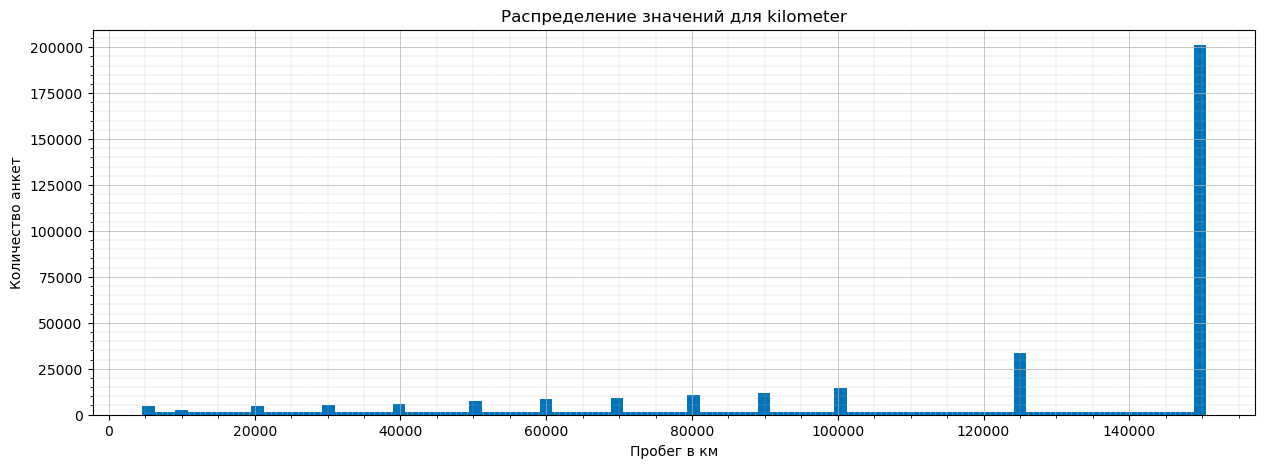

In [57]:
get_histplot(df['kilometer'], 'Пробег в км')

Признак действительно категориальный. Большинство анкет с пробегом 150000 км.

Целевой признак **price** (цена (евро))
Это признак, который будем предсказывать. Посмотрим на него:

In [58]:
df['price'].value_counts().sort_index().head(20)

0     6139
1      614
2        7
3        4
5        7
9        4
10      21
11       1
12       1
13       2
15       3
16       1
20       6
24       1
25       4
26       1
29       1
30      11
35       3
38       1
Name: price, dtype: int64

Есть нули. В реальной жизни они, скорее всего, означают объявления, в которых не указана цена. Много и таких объявлений, в которых указана цена 1 евро. 
Проверим, много ли объявлений с ценой до 100.

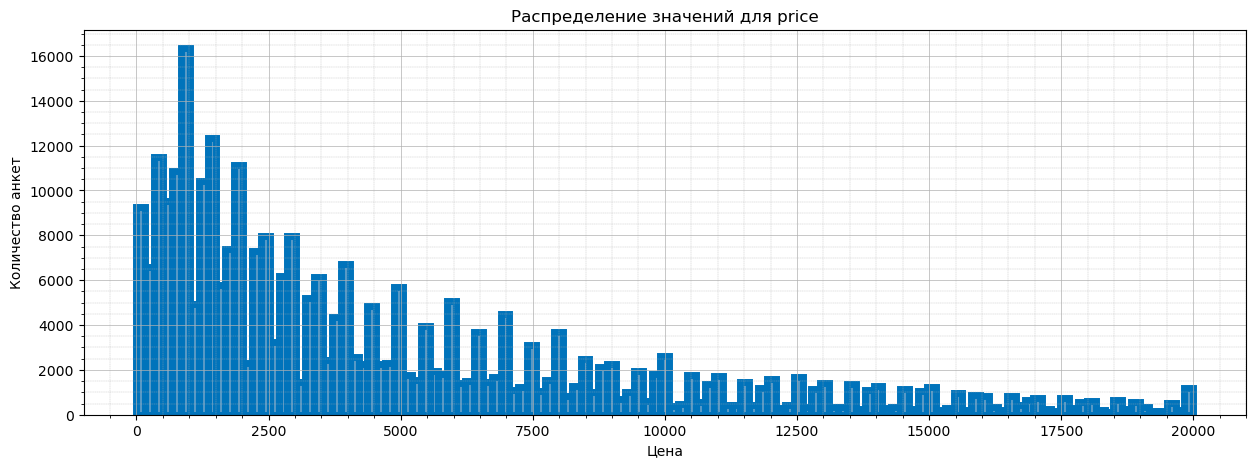

In [59]:
get_histplot(df['price'], 'Цена', kde=False)

In [60]:
print(f"Объявлений дешевле 100 евро {df[df['price'] < 100].shape[0]} шт., "
      f"это {df[df['price'] < 100].shape[0]/df.shape[0]:.2%}")

Объявлений дешевле 100 евро 7250 шт., это 2.43%


Удалим объекты с ценой меньше 100 евро

In [61]:
df = df[df['price'] >= 100]
len(df[df['price'] < 100])

0

Разобрались с признаками, избавились от аномальных и пропущенных значений. Посмотрим, что в итоге:

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290902 entries, 1 to 354364
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         290902 non-null  int64 
 1   vehicle_type  290902 non-null  object
 2   gearbox       290902 non-null  object
 3   power         290902 non-null  int64 
 4   model         290902 non-null  object
 5   kilometer     290902 non-null  int64 
 6   fuel_type     290902 non-null  object
 7   brand         290902 non-null  object
 8   repaired      290902 non-null  object
 9   car_age       290902 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.4+ MB


In [63]:
(f'Удалено {start_size[0] - df.shape[0]} строк, '
    f'что составляет {1-df.shape[0] /start_size[0]:.2%} от изначального датафрейма')

'Удалено 63463 строк, что составляет 17.91% от изначального датафрейма'

Объединим признаки **brand** и **model**

Данные проанализированы и подготовлены к Machine Learning

## Обучение моделей

Будем обучать следующие модели:

LinearRegression  
LGBMRegressor  
CatBoostRegressor  
Ridge  
GradientBoostingRegressor  
Подбирать гиперпараметры будем при помощи GridSearchCV  

Критериями качества моделей будет:  

метрика RMSE (Root Mean Squared Error) 
время затраченное алгоритмами на обучение моделей и предсказания  

Подготовка к обучению и тестированию моделей
Разобьем датафрейм на выборки с учетом индексации

РАзделим на таргеты и признаки и на тестовую и обучающую выборку и разобьем данные сначала на обучающую выборку 75% тестовую 25%

In [64]:
y = df['price']
X = df.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE)

Выделим категориальные и числовые признаки

In [65]:
cat = list(X_train.select_dtypes(include='object').columns)
num = list(X_train.select_dtypes(include='int64').columns)
print(cat)
num

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


['power', 'kilometer', 'car_age']

Создадим препроцессор для кодировщика и стандартизатора

In [66]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num),
        ('cat', categorical_transformer, cat)
    ])

Посмотрим на кросс-валидации какие модели возьмем для поиска гиперпараметров, по значению метрики RMSE

**LinearRegression**

In [67]:
lr = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat)),
    ('regressor', LinearRegression())
])


cvs_lr = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение  линейной регрессии на кросс валидации:", -cvs_lr)

Лучшее значение  линейной регрессии на кросс валидации: 2619.9180991209046


**LGBMRegressor**

In [68]:
lg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE))
])

cvs_lg = cross_val_score(lg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение  LGBM на кросс валидации:", -cvs_lg)

Лучшее значение  LGBM на кросс валидации: 1597.741453297839


**CatBoostRegressor**

In [69]:
ct = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE))
])

cvs_ct = cross_val_score(ct, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение  CatBoost на кросс валидации:", -cvs_ct)

Лучшее значение  CatBoost на кросс валидации: 1525.6680119827865


**Ridge**

In [70]:
rg = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat)),
    ('regressor', Ridge())
])


cvs_rg = cross_val_score(rg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
print("Лучшее значение Ridge на кросс валидации:", -cvs_rg)

Лучшее значение Ridge на кросс валидации: 2619.918099274439


Найдем гиперпараметры с помощью GridSearchCV и время обучения и предсказания для всех моделей

**Linear Regression**

In [71]:
pipe_lr = Pipeline(steps=[
    ('encoder', TargetEncoder(cols=cat)),
    ('regressor', LinearRegression())
])

#параметры для GridSearch
param_grid = { }

#объект GridSearchCV
grid_search_lr = GridSearchCV(pipe_lr, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

#обучение на трейне
grid_search_lr.fit(X_train, y_train)

#результаты кросс-валидации
print("Best cross-validation score: ", -grid_search_lr.best_score_)

Best cross-validation score:  2619.9180991209046


In [72]:
cv_results_lr = grid_search_lr.cv_results_
print("Среднее время обучения LinearRegression:", cv_results_lr['mean_fit_time'].mean())
print("Среднее время предсказания LinearRegression:", cv_results_lr['mean_score_time'].mean())

Среднее время обучения LinearRegression: 1.8352877616882324
Среднее время предсказания LinearRegression: 0.1429070472717285


**CatBoostRegression**

In [73]:
pipe_ct = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(random_state=RANDOM_STATE))
])

param_grid = {
    'regressor__learning_rate': [0.1, 0,3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}

grid_search_cb = GridSearchCV(pipe_ct, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search_cb.fit(X_train, y_train)

print("Best parameters: ", grid_search_cb.best_params_)
print("Best cross-validation score: ", -grid_search_cb.best_score_)

0:	learn: 4273.0340701	total: 87.9ms	remaining: 26.3s
1:	learn: 4004.3501174	total: 105ms	remaining: 15.7s
2:	learn: 3753.8211454	total: 122ms	remaining: 12s
3:	learn: 3534.9173802	total: 139ms	remaining: 10.3s
4:	learn: 3336.8331960	total: 155ms	remaining: 9.13s
5:	learn: 3168.1822227	total: 171ms	remaining: 8.37s
6:	learn: 3014.9264062	total: 186ms	remaining: 7.79s
7:	learn: 2878.0268431	total: 203ms	remaining: 7.43s
8:	learn: 2760.1606884	total: 219ms	remaining: 7.07s
9:	learn: 2656.6702479	total: 234ms	remaining: 6.77s
10:	learn: 2558.7186794	total: 249ms	remaining: 6.54s
11:	learn: 2475.1365708	total: 265ms	remaining: 6.37s
12:	learn: 2403.4173965	total: 281ms	remaining: 6.2s
13:	learn: 2339.6057596	total: 298ms	remaining: 6.08s
14:	learn: 2282.6447256	total: 315ms	remaining: 5.98s
15:	learn: 2231.2200888	total: 332ms	remaining: 5.89s
16:	learn: 2187.3061898	total: 349ms	remaining: 5.8s
17:	learn: 2146.1770566	total: 365ms	remaining: 5.72s
18:	learn: 2108.9935477	total: 384ms	rema

In [74]:
cv_results_cb = grid_search_cb.cv_results_
print("Среднее время обучения Catboost:", cv_results_cb['mean_fit_time'].mean())
print("Среднее время предсказания Catboost:", cv_results_cb['mean_score_time'].mean())

Среднее время обучения Catboost: 23.025667226314543
Среднее время предсказания Catboost: 0.5421404321988424


**LGBMRegressor**

In [75]:
pipe_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(random_state=RANDOM_STATE))
])

param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

grid_search_lgbm = GridSearchCV(pipe_lgbm, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search_lgbm.fit(X_train, y_train)

print("Best parameters: ", grid_search_lgbm.best_params_)
print("Best cross-validation score: ", -grid_search_lgbm.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 615
[LightGBM] [Info] Number of data points in the train set: 218176, number of used features: 9
[LightGBM] [Info] Start training from score 4836.314815
Best parameters:  {'regressor__learning_rate': 0.2, 'regressor__max_depth': 15, 'regressor__n_estimators': 350}
Best cross-validation score:  1491.7930733661465


In [76]:
cv_results_lgbm = grid_search_lgbm.cv_results_
print("Среднее время обучения LGBM:", cv_results_lgbm['mean_fit_time'].mean())
print("Среднее время предсказания LGBM:", cv_results_lgbm['mean_score_time'].mean())

Среднее время обучения LGBM: 28.02156527042389
Среднее время предсказания LGBM: 0.33748795191446934


In [77]:
pipe_rg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=RANDOM_STATE))
])

param_grid = {'regressor__alpha': [.1, 1, 10]}

grid_search_rg = GridSearchCV(pipe_rg, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

grid_search_rg.fit(X_train, y_train)

print("Best parameters: ", grid_search_rg.best_params_)
print("Best cross-validation score: ", -grid_search_rg.best_score_)

Best parameters:  {'regressor__alpha': 0.1}
Best cross-validation score:  2619.918100228254


In [78]:
cv_results_rg = grid_search_rg.cv_results_
print("Среднее время обучения Ridge:", cv_results_rg['mean_fit_time'].mean())
print("Среднее время предсказания Ridge:", cv_results_rg['mean_score_time'].mean())

Среднее время обучения Ridge: 2.1389007091522214
Среднее время предсказания Ridge: 0.18780361811319987


На этом этапе мы обучили и протестировали модели:  

LinearRegression  
LGBMRegressor  
CatBoostRegressor  
Ridge  

Подобрали гиперпараметры при помощи GridSearchCV.  

По результатам тестирования моделей:  
На первом месте по RMSE LGBMRegressor, показавший неплохое время на подбор гиперпараметров и обучение  
На втором месте по RMSE CatBoostRegressor.
Проведем бэггинг и анализ моделей по лучшим моделям.
Остальные модели не отвечают нашим критериям  

## Анализ моделей

Создадим бэггинг из лучших моделей

**LGBMRegressor & CatBoostRegression Bagging**

In [79]:
#создадим базовые модели
catboost = CatBoostRegressor(learning_rate=0.1, n_estimators=300, random_state=RANDOM_STATE)
lgbm = LGBMRegressor(learning_rate=0.2, max_depth=15, n_estimators=350, random_state=RANDOM_STATE)

#создадим бэггинг-модель
bagging = BaggingRegressor(base_estimator=lgbm, n_estimators=6)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('bagging', bagging)
])

param_grid = { }

search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

search_bagging.fit(X_train, y_train)

print("Best cross-validation score: ", -search_bagging.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 616
[LightGBM] [Info] Number of data points in the train set: 218176, number of used features: 9
[LightGBM] [Info] Start training from score 4840.554937
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead o

In [80]:
cv_results_bagging = search_bagging.cv_results_
print("Среднее время обучения Bagging:", cv_results_bagging['mean_fit_time'].mean())
print("Среднее время предсказания Bagging:", cv_results_bagging['mean_score_time'].mean())

Среднее время обучения Bagging: 37.19268174171448
Среднее время предсказания Bagging: 1.0474422931671143


Создадим константную модель для проверки адекватности наших моделей

In [81]:
dummy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))

RMSE DummyRegressor равен: 4607.65


Проверим **LGBMRegressor** на тестовой выборке

In [82]:
%%time
bg_test = search_bagging.best_estimator_.predict(X_test)
RMSE = mean_squared_error(y_test, bg_test, squared=False)
print('RMSE bagging тест равен:', round(RMSE, 2))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE bagging тест равен: 1494.53
Wall time: 1.21 s


In [83]:
%%time
test_lg = grid_search_lgbm.best_estimator_.predict(X_test)
RMSE = mean_squared_error(y_test, test_lg, squared=False)
print('RMSE LGBM тест равен:', round(RMSE, 2))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
RMSE LGBM тест равен: 1504.01
Wall time: 508 ms


Выбранные модели точно адекватны по сравнению с константной.

**Вывод**   
В процессе работы над проектом:

- Загрузили и изучили данные     
- Заполнили пропущенные значения и обработать аномалии в признаках. Удалили неинформативные признаки  
- Подготовили выборки для обучения моделей 
- Обучили модели:  
  линейные: LinearRegression и Ridge    
  бустинги: LGBMRegressor, CatBoostRegressor  
- Проанализировали время обучения, время предсказания и качество моделей.  
Лучше всего себя себя показал LGBMRegressor:    
На тренировочной выборке: RMSE: 1491.8, Время обучения: 8.38с, время предсказания L: 1.11с.  
На тестовой выборке: RMSE: 1504.01, Время предсказания: 1.89с.  
Опираясь на критерии заказчика, можно рекомендовать сервису «Не бит, не крашен» обученую модель LGBMRegressor.